In [78]:
# !pip install -U sagemaker
# !pip install -U pip

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.5 MB 13.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3
    Uninstalling pip-20.3:
      Successfully uninstalled pip-20.3


In [1]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'sagemaker/DEMO-xgboost-churn'
region = 'us-east-1'

import boto3
import re

from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime,gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [3]:
# !wget http://dataminingconsultant.com/DKD2e_data_sets.zip
# !unzip -o DKD2e_data_sets.zip

In [6]:
churn = pd.read_csv('churn.txt')
pd.set_option('display.max_columns',None)
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [23]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   object 
 3   Int'l Plan      3333 non-null   object 
 4   VMail Plan      3333 non-null   object 
 5   VMail Message   3333 non-null   int64  
 6   Day Mins        3333 non-null   float64
 7   Day Calls       3333 non-null   int64  
 8   Day Charge      3333 non-null   float64
 9   Eve Mins        3333 non-null   float64
 10  Eve Calls       3333 non-null   int64  
 11  Eve Charge      3333 non-null   float64
 12  Night Mins      3333 non-null   float64
 13  Night Calls     3333 non-null   int64  
 14  Night Charge    3333 non-null   float64
 15  Intl Mins       3333 non-null   float64
 16  Intl Calls      3333 non-null   int64  
 17  Intl Charge     3333 non-null   f

In [19]:
churn.isnull().sum()

State             0
Account Length    0
Area Code         0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [12]:
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column],columns='% observations',normalize='columns'))

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
...,...
422-7728,0.0003
422-8268,0.0003
422-8333,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


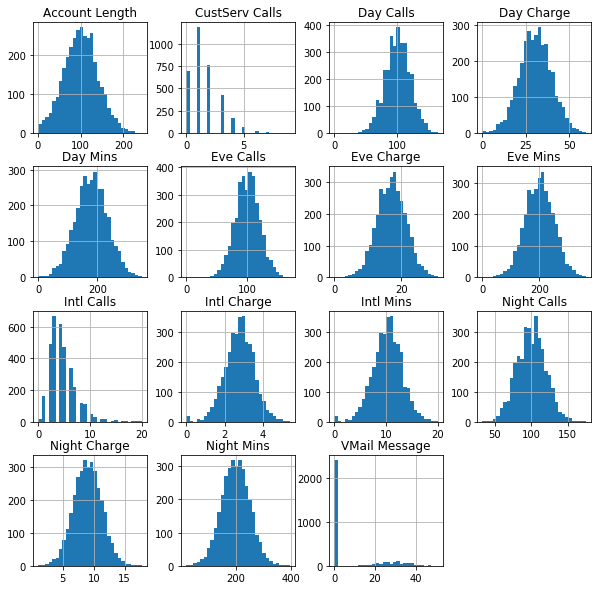

In [22]:
churn.describe()
%matplotlib inline
hist = churn.hist(bins=30,sharey=False,figsize=(10,10))

In [16]:
churn.drop('Phone',axis=1,inplace=True)

In [18]:
churn['Area Code'] = churn['Area Code'].astype(object)

In [33]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?': 
        display(pd.crosstab(index=churn[column],columns=churn['Churn?'],normalize='columns'))

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


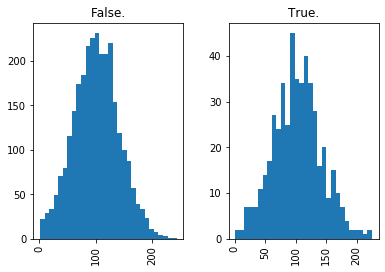

VMail Message


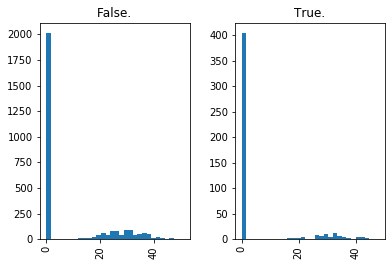

Day Mins


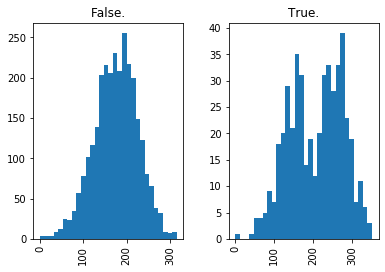

Day Calls


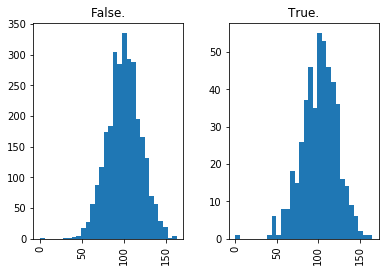

Day Charge


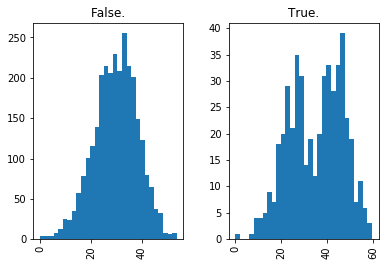

Eve Mins


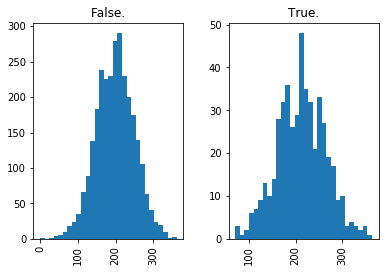

Eve Calls


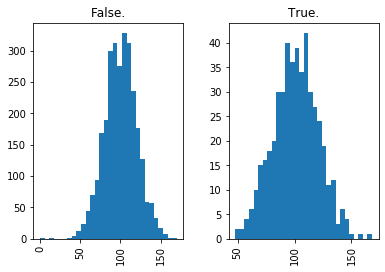

Eve Charge


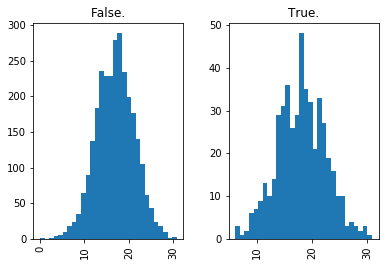

Night Mins


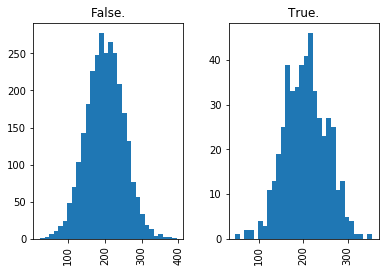

Night Calls


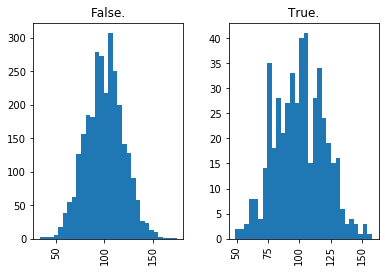

Night Charge


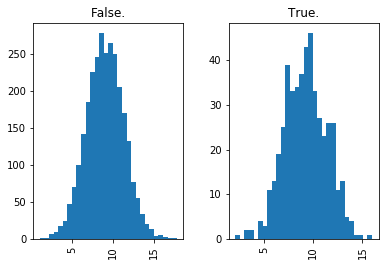

Intl Mins


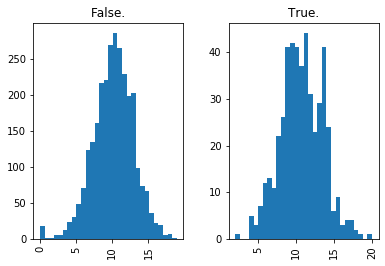

Intl Calls


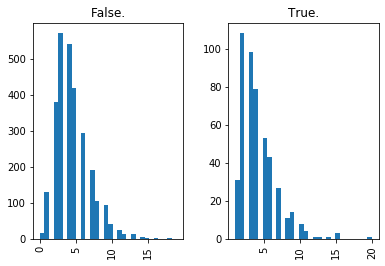

Intl Charge


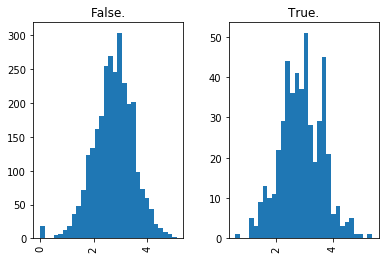

CustServ Calls


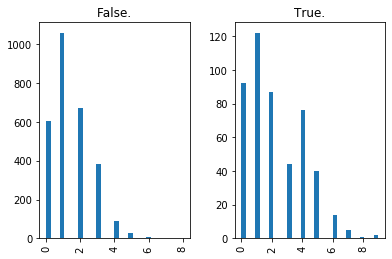

In [34]:
for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

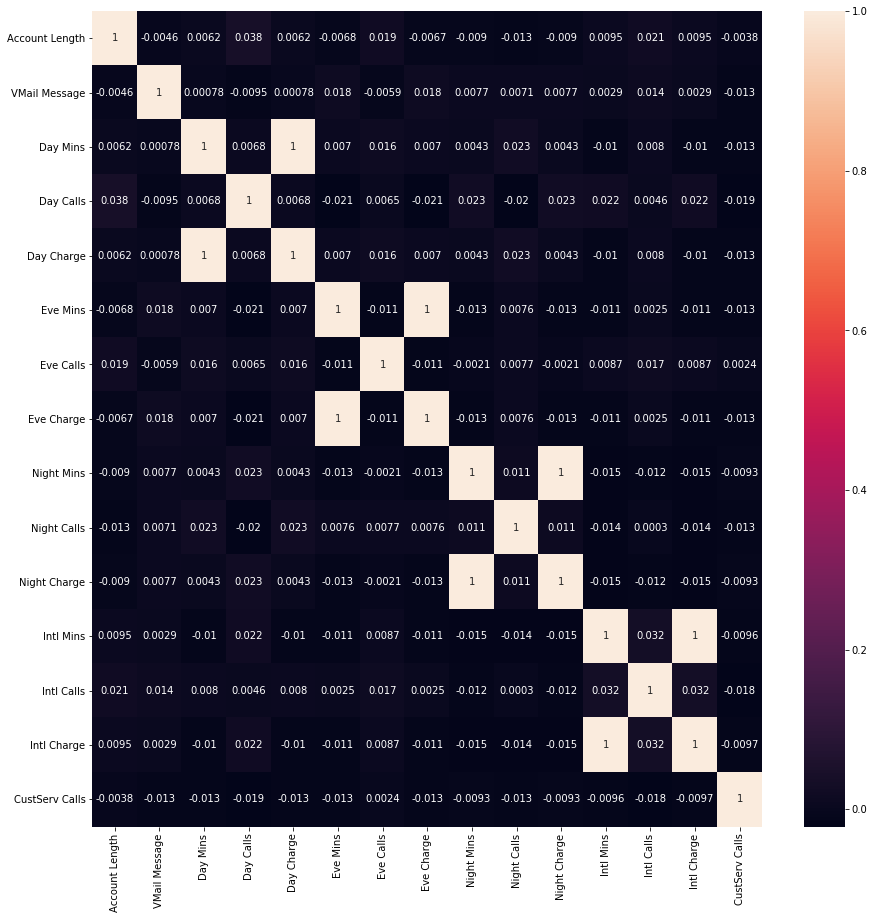

In [39]:
plt.figure(figsize=(15,15))
sns.heatmap(churn.corr(),annot=True)
plt.show()

In [40]:
churn.drop(['Day Charge','Eve Charge','Night Charge','Intl Charge'],axis=1,inplace=True)

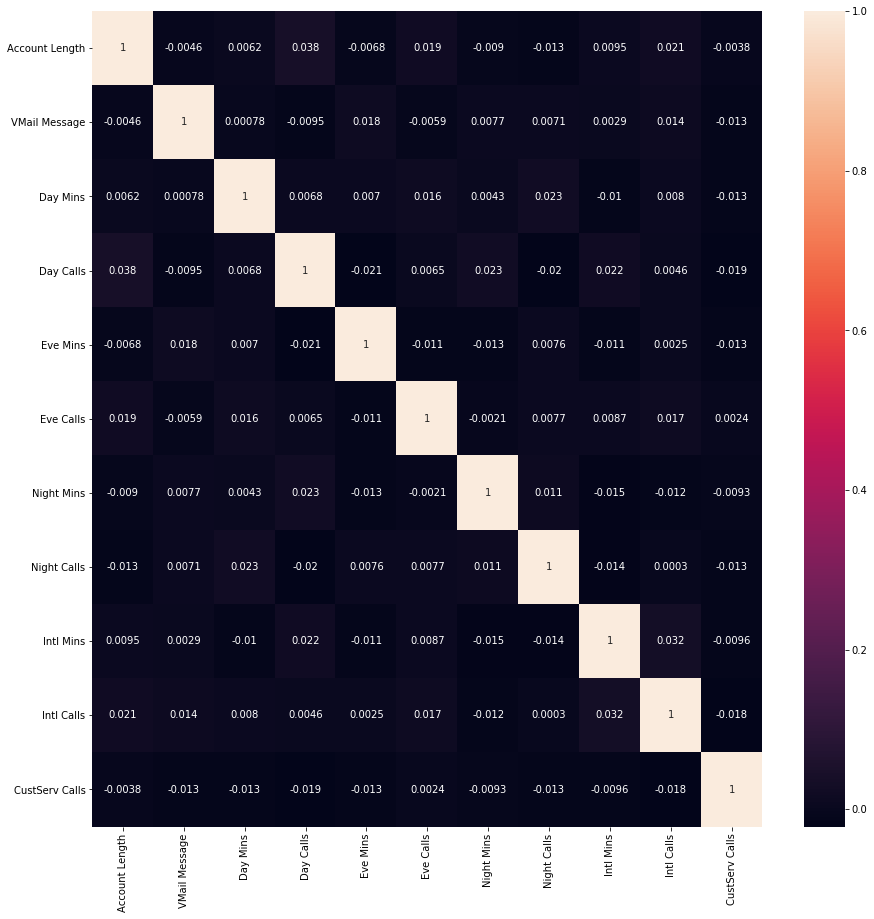

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(churn.corr(),annot=True)
plt.show()

In [42]:
model_data = pd.get_dummies(churn)

In [44]:
model_data.columns.tolist()

['Account Length',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Eve Mins',
 'Eve Calls',
 'Night Mins',
 'Night Calls',
 'Intl Mins',
 'Intl Calls',
 'CustServ Calls',
 'State_AK',
 'State_AL',
 'State_AR',
 'State_AZ',
 'State_CA',
 'State_CO',
 'State_CT',
 'State_DC',
 'State_DE',
 'State_FL',
 'State_GA',
 'State_HI',
 'State_IA',
 'State_ID',
 'State_IL',
 'State_IN',
 'State_KS',
 'State_KY',
 'State_LA',
 'State_MA',
 'State_MD',
 'State_ME',
 'State_MI',
 'State_MN',
 'State_MO',
 'State_MS',
 'State_MT',
 'State_NC',
 'State_ND',
 'State_NE',
 'State_NH',
 'State_NJ',
 'State_NM',
 'State_NV',
 'State_NY',
 'State_OH',
 'State_OK',
 'State_OR',
 'State_PA',
 'State_RI',
 'State_SC',
 'State_SD',
 'State_TN',
 'State_TX',
 'State_UT',
 'State_VA',
 'State_VT',
 'State_WA',
 'State_WI',
 'State_WV',
 'State_WY',
 'Area Code_408',
 'Area Code_415',
 'Area Code_510',
 "Int'l Plan_no",
 "Int'l Plan_yes",
 'VMail Plan_no',
 'VMail Plan_yes',
 'Churn?_False.',
 'Churn?_True.']

In [46]:
model_data = pd.concat([model_data['Churn?_True.'],model_data.drop(['Churn?_False.','Churn?_True.'],axis=1)],axis=1)

In [47]:
model_data.sample(5)

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
596,0,124,0,157.5,70,130.7,79,193.4,98,9.6,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
750,0,146,32,154.0,80,185.5,91,148.2,107,8.2,4,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1211,0,94,0,174.0,85,241.1,114,207.8,94,7.9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1079,0,158,0,209.9,112,221.3,82,210.0,93,8.2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1132,0,83,37,78.5,109,210.5,101,179.7,102,11.8,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1


In [51]:
train_data,validation_data,test_data = np.split(model_data.sample(frac=1,random_state=100),[int(0.7 * len(model_data)),int(0.9 * len(model_data))])

In [56]:
train_data.shape,validation_data.shape,test_data.shape

((2333, 70), (666, 70), (334, 70))

In [74]:
train_data.to_csv('train.csv',header=False,index=False)
validation_data.to_csv('validation.csv',header=False,index=False)

In [75]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,'validation/validation.csv')).upload_file('validation.csv')

In [81]:
container = sagemaker.image_uris.retrieve('xgboost',region=region,version='latest')
container

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

In [82]:
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket,prefix),content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket,prefix),content_type='csv')

In [85]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,prefix),
                                    sagmaker_session=sess,
                                    use_spot_instances=True,
                                    max_run=300,
                                    max_wait=600)


In [87]:
xgb.set_hyperparameters(max_depth=5,
                       eta=0.2,
                       gamma=4,
                       min_child_weight=6,
                       sub_sample=0.8,
                       silent=0,
                       objective='binary:logistic',
                       num_round=100)

In [88]:
xgb.fit({'train':s3_input_train,'validation':s3_input_validation})

2021-02-01 10:41:10 Starting - Starting the training job...
2021-02-01 10:41:33 Starting - Launching requested ML instancesProfilerReport-1612176070: InProgress
......
2021-02-01 10:42:33 Starting - Preparing the instances for training......
2021-02-01 10:43:34 Downloading - Downloading input data...
2021-02-01 10:44:03 Training - Downloading the training image...
2021-02-01 10:44:37 Uploading - Uploading generated training model
2021-02-01 10:44:37 Completed - Training job completed
Arguments: train
[2021-02-01:10:44:25:INFO] Running standalone xgboost training.
[2021-02-01:10:44:25:INFO] File size need to be processed in the node: 0.46mb. Available memory size in the node: 8427.1mb
[2021-02-01:10:44:25:INFO] Determined delimiter of CSV input is ','
[10:44:25] S3DistributionType set as FullyReplicated
[10:44:25] 2333x69 matrix with 160977 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-02-01:10:44:25:INFO] Determined delimiter of CSV input is '

In [95]:
compile_model = xgb
output_path = '/'.join(xgb.output_path.split('/')[:-1])
compiled_model = xgb.compile_model(target_instance_family='ml_m4',
                                  input_shape={'data':[1,69]},
                                  role=role,
                                  framework='xgboost',
                                  framework_version='latest',
                                  output_path=output_path)
compiled_model.name = 'deployed-xgboost-customer-churn'
                                  

?...!

In [96]:
xgb_predictor = compiled_model.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge',serializer=CSVSerializer())

-------------!

In [97]:
def predict(data,rows=500):
    split_array = np.array_split(data,int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions,xgb_predictor.predict(array).decode('utf-8')])
        
    return np.fromstring(predictions[1:],sep=',')

In [99]:
predictions = predict(test_data.to_numpy()[:,1:])

In [104]:
predictions

array([0.02594591, 0.87425381, 0.88970101, 0.81949139, 0.06165822,
       0.04286226, 0.03014403, 0.03212696, 0.02835068, 0.02520415,
       0.55749536, 0.05255663, 0.84357113, 0.03186052, 0.83135992,
       0.02540862, 0.05136523, 0.03575252, 0.04206654, 0.0514032 ,
       0.02671551, 0.0618718 , 0.05009561, 0.14552283, 0.05938876,
       0.3345288 , 0.02519504, 0.03420733, 0.04359508, 0.03247365,
       0.037157  , 0.5665853 , 0.04921982, 0.0253966 , 0.11295935,
       0.40702549, 0.09085592, 0.02153492, 0.0267715 , 0.17632625,
       0.02690253, 0.86571777, 0.02630814, 0.05252694, 0.07374097,
       0.04555284, 0.9644559 , 0.02958471, 0.04366815, 0.03282204,
       0.24802998, 0.03489002, 0.95396399, 0.04298882, 0.02981831,
       0.02803588, 0.82402748, 0.02593987, 0.04883948, 0.02992702,
       0.03206083, 0.04267325, 0.04095084, 0.02511421, 0.25276509,
       0.03103437, 0.02987686, 0.09490937, 0.8266955 , 0.30493313,
       0.02681151, 0.02785574, 0.02908033, 0.03939512, 0.02648

In [102]:
pd.crosstab(index=test_data.iloc[:,0],columns=np.round(predictions),rownames=['actual'],colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,287,0
1,6,41


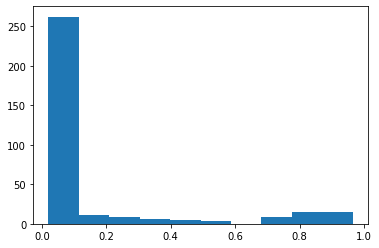

In [106]:
plt.hist(predictions)
plt.show()

In [110]:
pd.crosstab(index=test_data.iloc[:,0],columns=np.where(predictions > 0.5,1,0),rownames=['actual'],colnames=['predictions'])

predictions,0,1
actual,,
0,287,0
1,6,41


In [134]:
# cutoffs = np.arange(0.01, 1, 0.01)
# costs = []
# for c in cutoffs:
#     costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
#                                pd.crosstab(index=test_data.iloc[:, 0], 
#                                            columns=np.where(predictions > c, 1, 0)))))

# costs = np.array(costs)
# plt.plot(cutoffs, costs)
# plt.show()

ValueError: Unable to coerce to DataFrame, shape must be (2, 1): given (2, 2)

In [ ]:
# print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

In [135]:
xgb_predictor.delete_endpoint()